In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf

from keras.layers import Activation, Conv2D, MaxPooling2D,UpSampling2D, Input
from keras.layers import BatchNormalization as BN
from keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from keras.models import Model


!wget https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
!wget https://www.dropbox.com/s/gstpamhin8rlhlg/masks.npy

--2023-06-02 09:51:44--  https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qii26wuxcbxw169/images.npy [following]
--2023-06-02 09:51:45--  https://www.dropbox.com/s/raw/qii26wuxcbxw169/images.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2e4a557e95652d5d646c18773.dl.dropboxusercontent.com/cd/0/inline/B9OpdyfKLKOhVtv3uO4SiAUhTB-42-QVGlDxDp__ukIOrC8fqSNy08B-7hdLlPHWdZyFpVYIJfJgffY4ZYgy4E8hSG5t3-b9FO7k1LhoN-cfawEPVlqaOXfnaNc42WyGh1j2uKWJZPbgZewLa1fEX9t_FzYR71HNfV1c8l3K0f9anA/file# [following]
--2023-06-02 09:51:45--  https://uce2e4a557e95652d5d646c18773.dl.dropboxusercontent.com/cd/0/inline/B9OpdyfKLKOhVtv3uO4SiAUhTB-42-QVGlDxDp__ukIOrC8fqSNy08B-7hdLlPHWdZyFpVYIJfJgffY4ZYgy4E

(20, 584, 584, 3)


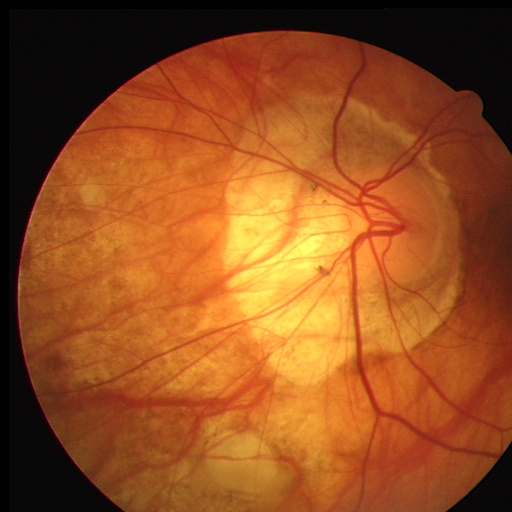

(20, 584, 584)


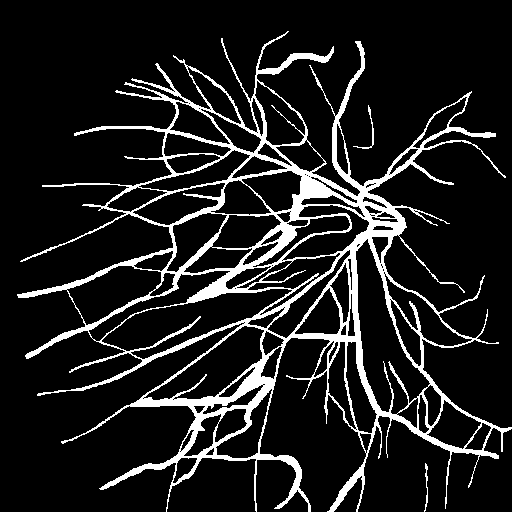

0.0 1.0


In [12]:
images=np.load("images.npy")
print(images.shape)
## Crop 512
images=images[:,0:512,0:512,:]

im=Image.fromarray(images[2])
im.show()

masks=np.load("masks.npy")
print(masks.shape)
## Crop 512
masks=masks[:,0:512,0:512]

im=Image.fromarray(masks[2])
im.show()

#Normalization
images=images/np.max(images)
masks=masks/np.max(masks)

print(np.min(masks[2]),np.max(masks[2]))

In [3]:
def EncBlock(layer,num,filters):
	l=layer
	for i in range(num):
		l=Conv2D(filters, (3, 3), padding='same')(l)
		l=BN()(l)
		l=Activation('relu')(l)

	m=MaxPooling2D((2,2))(l)

	return l,m

In [4]:
def DecBlock(layer,layer2,num,filters,enclayer=None):
		u=UpSampling2D((2,2))(layer)
		l=Conv2D(filters, (1, 1), padding='same')(u)
		l=concatenate([l, layer2], axis=3)

		for i in range(num):
			l=Conv2D(filters, (3, 3), padding='same')(l)
			l=BN()(l)
			l=Activation('relu')(l)
		

		return l

In [5]:
def conv(layer,num,filters,enclayer=None):
	l=layer

	for i in range(num):
		l=Conv2D(filters, (3, 3), padding='same')(l)
		l=BN()(l)
		l=Activation('relu')(l)

	return l

In [6]:
def EncDec(x0):
		## Enc
		l1, m1 =EncBlock(x0,2,32) # 256
		l2, m2=EncBlock(m1,2,64) #128
		l3, m3=EncBlock(m2,2,128) #64
		l4, m4=EncBlock(m3,2,256) #32
	
		## bridge
		b3=conv(m4,2,512)
		
		## Dec
		d1=DecBlock(b3,l4,2,256) #64
		d2=DecBlock(d1,l3,2,128) #128
		d3=DecBlock(d2,l2, 2,64)#256
		d4=DecBlock(d3,l1, 2,32)#512  

		d5=Conv2D(1, (1, 1), padding='same')(d4)

		return d5

In [7]:
lin=Input((512,512,3))
out=Activation('sigmoid')(EncDec(lin))

opt = Adam(learning_rate=0.001)

model = Model(inputs=lin, outputs=out)
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mse'])
    
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
model.fit(images,masks,batch_size=4,epochs=200,verbose=1)

Epoch 1/200
5/5 [==============================] - 120s 23s/step - loss: 0.7809 - mse: 0.2826
Epoch 2/200
5/5 [==============================] - 113s 22s/step - loss: 0.5473 - mse: 0.1805
Epoch 3/200
5/5 [==============================] - 114s 23s/step - loss: 0.4736 - mse: 0.1465
Epoch 4/200
5/5 [==============================] - 112s 23s/step - loss: 0.4519 - mse: 0.1381
Epoch 5/200
5/5 [==============================] - 120s 24s/step - loss: 0.4338 - mse: 0.1307
Epoch 6/200
5/5 [==============================] - 115s 23s/step - loss: 0.4100 - mse: 0.1209
Epoch 7/200
5/5 [==============================] - 115s 23s/step - loss: 0.3943 - mse: 0.1153
Epoch 8/200
5/5 [==============================] - 115s 23s/step - loss: 0.3786 - mse: 0.1086
Epoch 9/200
5/5 [==============================] - 114s 23s/step - loss: 0.3546 - mse: 0.0989
Epoch 10/200
5/5 [==============================] - 118s 24s/step - loss: 0.3311 - mse: 0.0885
Epoch 11/200
5/5 [==============================] - 122s 23

In [9]:
masks=model.predict(images)

1/1 [==============================] - 30s 30s/step


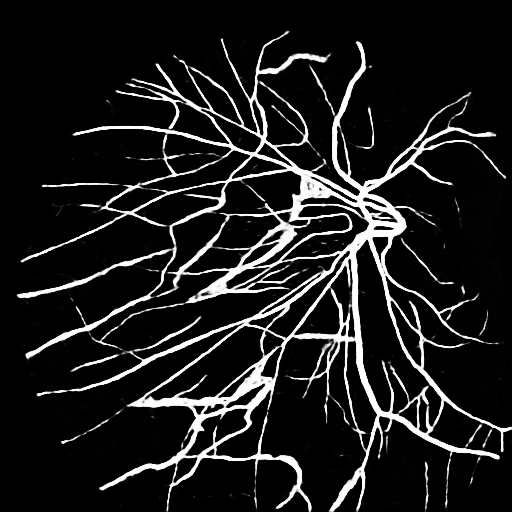

In [10]:
masks=masks*255
masks=np.uint8(masks)
im=Image.fromarray(masks[2,:,:,0])
im.show()